# Neo4j GDS Python Client
In the examples that follows, we will be using the Spark Connector running under PySpark
[Neo4j gds python client](https://neo4j.com/docs/graph-data-science/current/python-client/)

In [ ]:
## Setup Neo4j instance

Create a free account at [https://sandbox.neo4j.com](https://sandbox.neo4j.com). Choose the "Blank Sandbox - Graph Data Science" option.  When your sandbox has been created, fill in the Bolt URL and password below.

In [1]:
## install dependencies (restart kernal after install)

In [2]:
pip install graphdatascience

You should consider upgrading via the '/Users/anthonykrinsky/PycharmProjects/gcp-api-examples/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install seaborn

You should consider upgrading via the '/Users/anthonykrinsky/PycharmProjects/gcp-api-examples/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In the examples that follows, we will be using the new PySpark GraphDataScience client library.

# Setup Neo4j Graph Data Science API

In [4]:
from graphdatascience import GraphDataScience
import seaborn as sns
from matplotlib import pyplot as plt

In [5]:
neo4j_url = "bolt://<ip>:7687"
neo4j_user = "neo4j"
neo4j_password = "<pwd>"
neo4j_database= "neo4j"

Instiantiate Graph Data Science

In [6]:
gds = GraphDataScience(neo4j_url, auth=(neo4j_user, neo4j_password))

Check GDS version

In [7]:
gds.run_cypher('return gds.version() as gds_version')

,gds_version
0,2.0.1


# Load MSA data

Start by creating a [node key constraint](https://neo4j.com/docs/cypher-manual/current/constraints/) that requires that each MSA node has a unique name.

In [8]:
gds.run_cypher("""
CREATE CONSTRAINT msa_name IF NOT EXISTS ON (m:MSA) ASSERT m.name IS NODE KEY
""")

""


Now load the data. `LOAD CSV` assumes that all columns are text, so we have to cast the numeric columns to the appropriate data types.

In [9]:
gds.run_cypher("""
LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/smithna/datasets/main/CensusDemographicsByMetroArea.csv" 
AS row
WITH row WHERE row.name CONTAINS 'Metro'
MERGE (m:MSA {name:row.name})
SET m.population = toInteger(row.population),
m.medianHouseholdIncome = toInteger(row.medianHouseholdIncome),
m.medianHomePrice = toInteger(row.medianHomePrice),
m.percentOver25WithBachelors = toFloat(row.percentOver25WithBachelors)
RETURN count(m) as msaCount
""")

,msaCount
0,392


# Run Cypher queries for data profiling
Aggregate and find quantiles.

In [10]:
gds.run_cypher("""
MATCH (n)
WITH n, 
["population", "medianHouseholdIncome", "medianHomePrice", "percentOver25WithBachelors" ] AS metrics
UNWIND metrics as metric
WITH metric, n[metric] AS value
RETURN metric, min(value) AS minValue,
percentileCont(value, 0.25) AS percentile25, 
percentileCont(value, 0.50) AS percentile50, 
percentileCont(value, 0.75) AS percentile75, 
max(value) AS maxValue
""")

,metric,minValue,percentile25,percentile50,percentile75,maxValue
0,population,54773.0,143253.25,238024.5,574636.500,19294236.0
1,medianHouseholdIncome,15197.0,50804.75,56505.5,63392.000,122478.0
2,medianHomePrice,86800.0,149600.00,179050.0,238725.000,971300.0
3,percentOver25WithBachelors,12.9,22.10,27.5,33.525,62.1


Some of those quantiles look asymetrical. Lets plot histograms and see what happens if we apply a log transformation.
In the next section we are returning results of cypher to a data frame.

In [11]:
msa_df = gds.run_cypher("""
MATCH (m:MSA)
RETURN m.name AS msa, 
m.population AS population,
m.medianHouseholdIncome AS medianHouseholdIncome,
m.medianHomePrice AS medianHomePrice,
m.percentOver25WithBachelors as percentOver25WithBachelors
""")

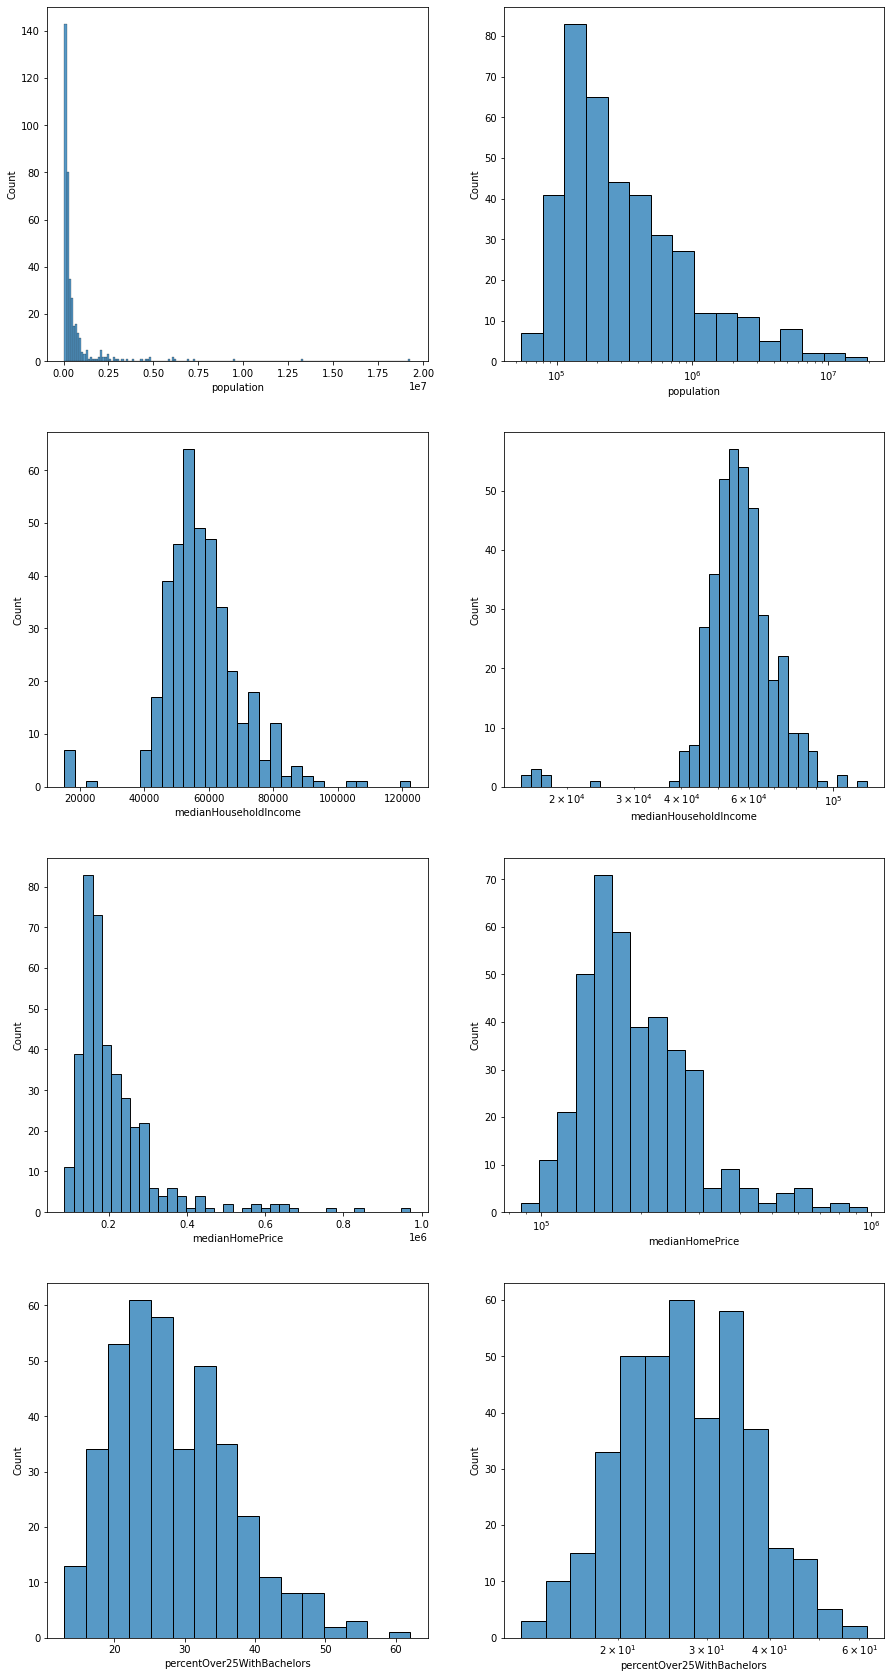

In [12]:
fig, axes = plt.subplots(4, 2)
fig.set_size_inches(15,30)
for i in range(1,5):
    sns.histplot(msa_df.iloc[:,i], ax=axes[i-1,0])
    sns.histplot(msa_df.iloc[:, i], log_scale=True, ax=axes[i-1,1])

That log transformation looks like it will help. Run the Cypher to store the transformed values in the graph.

In [13]:
gds.run_cypher("""
MATCH (m:MSA)
SET 
m.logPopulation = log(m.population),
m.logMedianHouseholdIncome = log(m.medianHouseholdIncome),
m.logMedianHomePrice = log(m.medianHomePrice),
m.logPercentOver25WithBachelors = log(m.percentOver25WithBachelors)
""")

""


# Create in-memory graph projection
Passing `"*"` as the third argument to `gds.graph.project` tells GDS to include any relationships that exist in the database in the in-memory graph. Because no relationships have been created in the graph yet, there will be no relationships in the in-memory graph projection when it is created.

In [19]:
g_msa, result = gds.graph.project(
    'msa-graph', 
    'MSA', 
    '*', 
    nodeProperties = [
        "logPopulation", 
        "logMedianHouseholdIncome", 
        "logMedianHomePrice", 
        "logPercentOver25WithBachelors"])

ClientError: Failed to invoke procedure `gds.graph.project`: Caused by: java.lang.IllegalArgumentException: A graph with name 'msa-graph' already exists.

Notice that when we look at the results of `gds.graph.project`, we see that the `relationshipCount` is 0.

In [15]:
result

nodeProjection            {'MSA': {'label': 'MSA', 'properties': {'logMe...
relationshipProjection    {'__ALL__': {'orientation': 'NATURAL', 'aggreg...
graphName                                                         msa-graph
nodeCount                                                               392
relationshipCount                                                         0
projectMillis                                                          1189
Name: 0, dtype: object

# Apply MinMax scalar to property values

In [16]:
gds.alpha.scaleProperties.mutate(g_msa, 
                                 nodeProperties = [
                                     "logPopulation", 
                                     "logMedianHouseholdIncome", 
                                     "logMedianHomePrice", 
                                     "logPercentOver25WithBachelors"], 
                                 scaler = "MinMax",
                                 mutateProperty = "scaledProperties")

nodePropertiesWritten                                                  392
mutateMillis                                                             2
postProcessingMillis                                                     0
preProcessingMillis                                                      2
computeMillis                                                           14
configuration            {'scaler': 'MINMAX', 'nodeLabels': ['*'], 'sud...
Name: 0, dtype: object

This next line streams node properties to the procedure caller.

In [17]:
sp = gds.graph.streamNodeProperty(g_msa, "scaledProperties")

In [18]:
import pandas as pd

<AxesSubplot:>

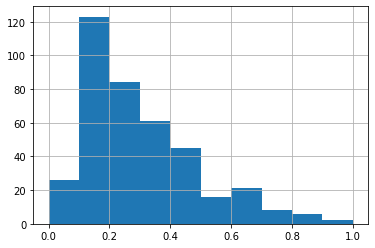

In [16]:
pd.DataFrame(list(sp['propertyValue'])).iloc[:,0].hist()

<AxesSubplot:>

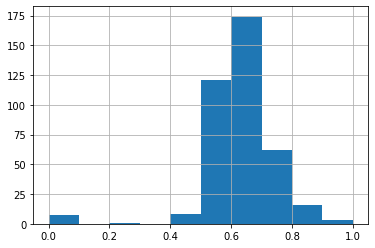

In [17]:
pd.DataFrame(list(sp['propertyValue'])).iloc[:,1].hist()

<AxesSubplot:>

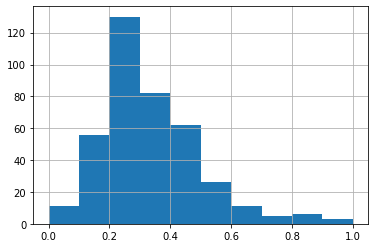

In [18]:
pd.DataFrame(list(sp['propertyValue'])).iloc[:,2].hist()

<AxesSubplot:>

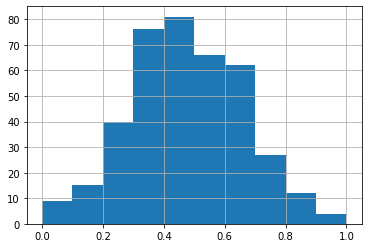

In [20]:
pd.DataFrame(list(sp['propertyValue'])).iloc[:,3].hist()

# Run KNN to create relationships to nearest neighbors
First run in stats mode and look at the similarity distribution.

In [29]:
knn_stats = gds.knn.stats(g_msa,
                          nodeProperties={"scaledProperties":"EUCLIDEAN"},
                          topK=15
                         )

In [30]:
knn_stats['similarityDistribution']

{'p1': 0.8350143432617188,
 'max': 0.9999847412109375,
 'p5': 0.9390525817871094,
 'p90': 0.996307373046875,
 'p50': 0.9895782470703125,
 'p95': 0.9975738525390625,
 'p10': 0.9621849060058594,
 'p75': 0.9938201904296875,
 'p99': 0.998992919921875,
 'p25': 0.98138427734375,
 'p100': 0.9999847412109375,
 'min': 0.77587890625,
 'mean': 0.9814903771796194,
 'stdDev': 0.027092446339228034}

Now run KNN in mutate mode to update the in-memory graph projection. We'll exclude the bottom 1% of similarity relationships.

In [31]:
gds.knn.mutate(g_msa,
               nodeProperties={"scaledProperties":"EUCLIDEAN"},
               topK=15,
               mutateRelationshipType="IS_SIMILAR",
               mutateProperty="similarity",
               similarityCutoff=knn_stats['similarityDistribution']['p1']
              )

ClientError: Failed to invoke procedure `gds.knn.mutate`: Caused by: java.lang.IllegalArgumentException: Relationship type `IS_SIMILAR` already exists in the in-memory graph.

Also write the relationships from the in-memory graph projection back to the on-disk graph.

In [32]:
gds.graph.writeRelationship(
    g_msa,
    "IS_SIMILAR",
    relationship_property="similarity"
)

writeMillis                   3985
graphName                msa-graph
relationshipType        IS_SIMILAR
relationshipProperty    similarity
relationshipsWritten          5822
propertiesWritten             5822
Name: 0, dtype: object

Add a `rank` property to the `IS_SIMILAR` relationships for use with Bloom filtering.

In [33]:
gds.run_cypher("""
MATCH (m:MSA)-[s:IS_SIMILAR]->()
WITH m, s ORDER BY s.similarity DESC
WITH m, collect(s) as similarities, range(0, 19) AS ranks
UNWIND ranks AS rank
WITH rank, similarities[rank] AS rel
SET rel.rank = rank + 1
""")

""


# Run Louvain community detection

In [34]:
gds.louvain.stats(g_msa,
                  relationshipTypes=["IS_SIMILAR"],
                 relationshipWeightProperty="similarity"
                 )

modularity                                                        0.628443
modularities                                          [0.6284429692667454]
ranLevels                                                                1
communityCount                                                          14
communityDistribution    {'p99': 59, 'min': 7, 'max': 59, 'mean': 28.0,...
postProcessingMillis                                                   201
preProcessingMillis                                                      1
computeMillis                                                         4421
configuration            {'maxIterations': 10, 'seedProperty': None, 'c...
Name: 0, dtype: object

In [35]:
gds.louvain.write(g_msa,
                  relationshipTypes=["IS_SIMILAR"],
                  relationshipWeightProperty ="similarity",
                  writeProperty="communityId")

writeMillis                                                            331
nodePropertiesWritten                                                  392
modularity                                                        0.628443
modularities                                          [0.6284429692667454]
ranLevels                                                                1
communityCount                                                          14
communityDistribution    {'p99': 59, 'min': 7, 'max': 59, 'mean': 28.0,...
postProcessingMillis                                                    16
preProcessingMillis                                                      0
computeMillis                                                         4467
configuration            {'maxIterations': 10, 'writeConcurrency': 4, '...
Name: 0, dtype: object

# Gather statistics about the communities that were discovered

Get average values for each community and 3 example MSAs for each community.

In [36]:
community_df = gds.run_cypher("""
MATCH (m:MSA)
WITH m 
ORDER BY apoc.coll.sum([(m)-[s:IS_SIMILAR]->(m2) 
WHERE m.communityId = m2.communityId | s.similarity]) desc
RETURN m.communityId as communityId,
count(m) as msaCount, 
avg(m.population) as avgPopulation,
avg(m.medianHomePrice) as avgHomePrice,
avg(m.medianHouseholdIncome) as avgIncome,
avg(m.percentOver25WithBachelors) as avgPctBachelors,
collect(m.name)[..3] as exampleMSAs
ORDER BY avgPopulation DESC
""")

In [27]:
community_df.sort_values('communityId')

,communityId,msaCount,avgPopulation,avgHomePrice,avgIncome,avgPctBachelors,exampleMSAs
0,None,392,720647.553571,212235.459184,57933.27551,28.521429,"[Abilene, TX Metro Area, Aguadilla-Isabela, PR..."


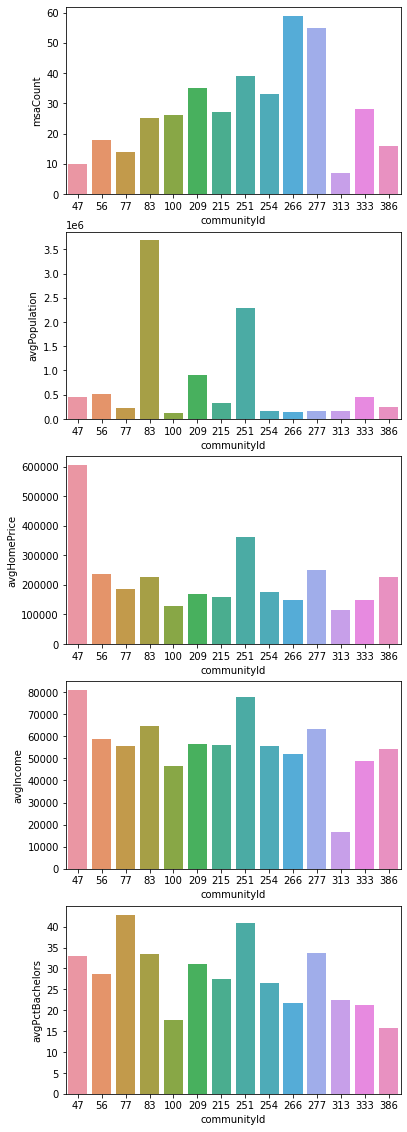

In [37]:
fig, axes = plt.subplots(5, 1)
fig.set_size_inches(6,20)
for i in range(1,6):
    sns.barplot(data=community_df, x="communityId", y=community_df.columns[i], ax=axes[i-1])

Mean can give us a quick overview of properties, but can be skewed by outliers. Compare emperical cumulative distribution function (ECDF) at various proportions to get a more complete picture of distributions.

In [38]:
detail_df = gds.run_cypher("""
MATCH (m:MSA)
RETURN "community " + m.communityId as communityId,
m.population as population,
m.medianHomePrice as medianHomePrice,
m.medianHouseholdIncome as medianIncome,
m.percentOver25WithBachelors as pctBachelors
order by m.communityId
""")

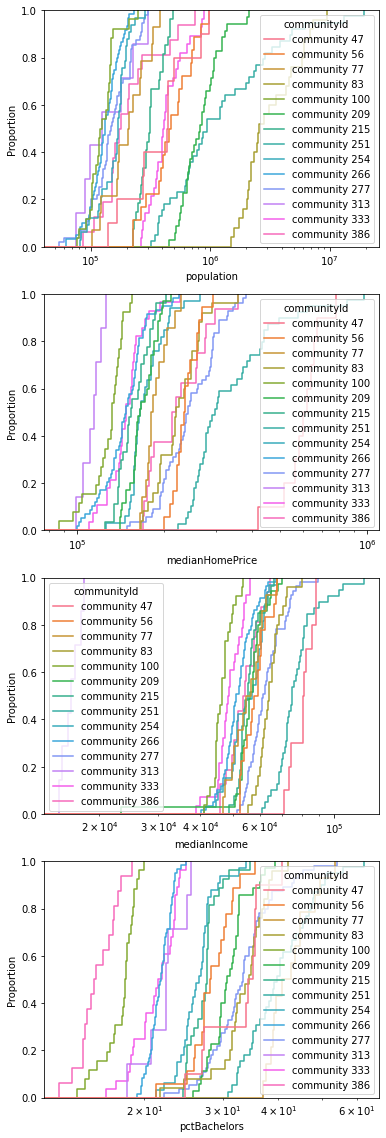

In [39]:
fig, axes = plt.subplots(4, 1)
fig.set_size_inches(6,20)
for i in range(1,5):
    sns.ecdfplot(data=detail_df, hue="communityId", x=detail_df.columns[i], log_scale=True, ax=axes[i-1])

Compare two-dimensions on scatter plots

[None]

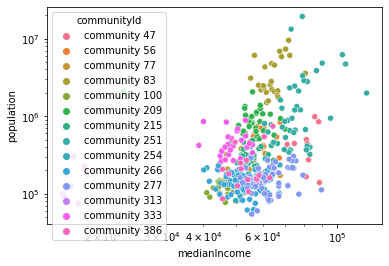

In [40]:
splot = sns.scatterplot(data=detail_df, x="medianIncome", y="population", hue="communityId")
splot.set(yscale="log")
splot.set(xscale="log")

[None]

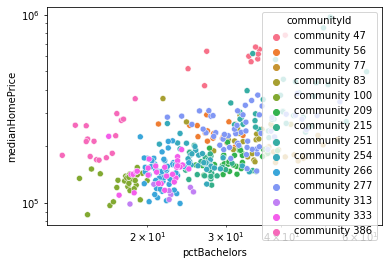

In [41]:
splot = sns.scatterplot(data=detail_df, x="pctBachelors", y="medianHomePrice", hue="communityId")
splot.set(yscale="log")
splot.set(xscale="log")

# Assign human-friendly names to the clusters discovered.
The Louvain community detection algorithm is not deterministic. You should have roughly the same clusters from previous runs, but some edge cases might be assigned to different communities. The community numbers might be shuffled between across different runs.
**This step requires adjustment by hand: choose from community IDs above.**

In [42]:
gds.run_cypher("""
MATCH (m:MSA) 
  SET m.communityName = CASE m.communityId 
  WHEN 54 THEN "Large mid-cost metros"
  WHEN 75 THEN "College towns"
  WHEN 81 THEN "Large high-cost metros"
  WHEN 234 THEN "Mid-size metros"
  WHEN 264 THEN "Small metros"
  WHEN 330 THEN "Mid-price metros"
  WHEN 385 THEN "Low-income metros"
  END
return m.communityName, m.communityId, count(*)
""")

,m.communityName,m.communityId,count(*)
0,None,266,59
1,None,313,7
2,None,209,35
3,None,100,26
4,None,251,39
5,None,56,18
6,None,215,27
7,None,77,14
8,None,254,33
9,None,83,25


Create an index on the `communityName` property to make it searchable in Bloom.

In [43]:
gds.run_cypher("""
CREATE INDEX msa_community_name IF NOT EXISTS
FOR (m:MSA)
ON (m.communityName)
""")

""
